# Capstone Project - The Battle of Neighborhoods (Week 2)

## Table of contents
* [Background](#background)
* [Introduction: Business Problem](#introduction)
* [Data description](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

### Background <a name="background"></a>

A multi national resturant chain is planning to expand their business in United states. The stakeholders (or) group of investors are interested to open a branch in one of the main cities in United states, but they don't have enough information about which city/location and type of restaurant could be more suitable for their business. 

Here the target audience is ofcourse the group of investors who needs extensive data report to solve thier business question at hand. Investors know the facts about developed country that generates significant revenue:

* Fourth largest area in the world.
* Third largest in population.
* Country with high gross domestic product (GDP) per capita

### Introduction: Business Problem <a name="introduction"></a>

This project will try to find possibly the best city along with type of restaurant to open a business in united states as stakeholders wants to extend their business anywhere in US.

Objective is to find and select the center of city where there are no such resturants in 2 mi radius. Another favourable factor for a resturtant business is a high densely populated city center.

### Data description <a name="data"></a>

Datasets needed to solve the problem:

* Details of largest population cities in US by 2020 - http://worldpopulationreview.com/countries/united-states-population/cities/ (Website has the details of 200 largest cities in the united states by population). However top 50 cities by rank will be considered for this problem scenario. (**Ex**: City name | Population | link- https://www.google.com/maps/?q=40.71427,-74.00597)


* City center coordinates (City map link has been included in the dataset as one of the column. Using some user defined function in python, latitude and longitude of city location need to be extracted. 
(**Ex**: https://www.google.com/maps/?q= **40.71427,-74.00597**)


* Foursqare API to retreive near by venues from the centre of city. (**EX**: City Name | Latitude | Longitude | Venue | Venue Latitude | Venue Longitude | Venue Category )

Below are the main factors model will concentrate on:

* Number of existing resturants in city with in 2 mi radius.
* Population of the city

Lets import all the libraries used in this notebook

In [1]:
#pip install lxml

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge folium --yes 

from geopy.geocoders import Nominatim
import requests
import folium
import re

pd.set_option('max_colwidth', -1)
pd.set_option('max_columns', None)

### Data Collection

Let's import the data set from website into pandas dataframe:

In [2]:
df_populated_cities=pd.read_json("data.json", orient='split')
df_populated_cities.reset_index(drop=False, inplace=True)
df_populated_cities.rename(columns={'asciiname':'city name', 'index':'rank'}, inplace=True)
df_populated_cities['rank']=df_populated_cities['rank']+1
df_populated_cities.set_index('rank', inplace=True)
df_populated_cities.head()

,city name,population,location
rank,,,
1,New York City,8175133,"https://www.google.com/maps/?q=40.71427,-74.00597"
2,Los Angeles,3971883,"https://www.google.com/maps/?q=34.05223,-118.24368"
3,Chicago,2720546,"https://www.google.com/maps/?q=41.85003,-87.65005"
4,Brooklyn,2300664,"https://www.google.com/maps/?q=40.6501,-73.94958"
5,Houston,2296224,"https://www.google.com/maps/?q=29.76328,-95.36327"


Now we need to city latitude and longitude to be further used in folium maps for data visualization. We have to use the geopy library and get the latitude and longitude for each city, but it is not needed here since the map links in location field has the city coordinates in it. So, all we need to do is simply extracting the data with the help of function. Let's create the user defined function using regular expression i.e. 're' module to extract the desired content.

In [3]:
def extract_coordinates(googlemaps):
    loc=re.findall(r'-*\d+.\d+', googlemaps)
    return pd.Series([float(loc[0]), float(loc[1])])

df_populated_cities[['latitude', 'longitude']]=df_populated_cities['location'].apply(extract_coordinates)

Ok. Now we have applied the function on dataframe to derive the two new columns i.e. 'Latitude' and 'longitude' for every row. Though we have imported all the rows from website which contains top 200 populated cities in US, only first 50 cities will be taken into consideration for now and will see what interesting facts we will come across. As high densely populated cities is one of the main factor for our model, its is important to concentrate on top cities.    

In [4]:
df_populated_cities=df_populated_cities.head(50)
df_populated_cities.head(3)

,city name,population,location,latitude,longitude
rank,,,,,
1,New York City,8175133,"https://www.google.com/maps/?q=40.71427,-74.00597",40.71427,-74.00597
2,Los Angeles,3971883,"https://www.google.com/maps/?q=34.05223,-118.24368",34.05223,-118.24368
3,Chicago,2720546,"https://www.google.com/maps/?q=41.85003,-87.65005",41.85003,-87.65005


Now we have dataset with basic cities information. So, lets create a folium map for all cities using latitude and longitude columns in dataframe as coordinated and see how it looks like:

In [5]:
coordinates=[37.0902, -95.7129]

US_cities=folium.Map(coordinates, zoom_start=4)

for row in df_populated_cities.itertuples(): 
    folium.CircleMarker(
        [row[4], row[5]],
        popup=row[1],
        radius=5,
        color='Magenta',
        fill=True,
        fill_color='Orange',
        fill_opacity=0.8
    ).add_to(US_cities)
    
US_cities

### Data Preparation and Data wrangling

Now we will focus on the next part of data preparation as we need to prepare the data of venues of each city with in 2 miles radius. Using Foursquare API and personal account credentials, we will make API calls for each city. Since the response from Foursquare API will be in json format, lets create a function to extract the required venues details and convert the required data into pandas dataframe. 

### Foursquare API

In [1]:
# Foursquare credentials was removed from this shared notebook


In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's apply the above function for each city name and assign the output returned by function to new dataframe

In [9]:
us_city_venues = getNearbyVenues(names=df_populated_cities['city name'],
                                   latitudes=df_populated_cities['latitude'],
                                   longitudes=df_populated_cities['longitude']
                                  )

New York City
Los Angeles
Chicago
Brooklyn
Houston
Queens
Philadelphia
Phoenix
Manhattan
San Antonio
San Diego
The Bronx
Dallas
San Jose
Austin
Jacksonville
San Francisco
Columbus
Fort Worth
Indianapolis
Charlotte
Seattle
Denver
El Paso
Detroit
Boston
Memphis
New South Memphis
Portland
Oklahoma City
Las Vegas
Baltimore
Washington, D.C.
Milwaukee
South Boston
Albuquerque
Tucson
Nashville
Fresno
Sacramento
Kansas City
Long Beach
Mesa
Staten Island
Atlanta
Colorado Springs
Virginia Beach
Raleigh
Omaha
Miami


In [118]:
us_city_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York City,40.71427,-74.00597,Heyday,40.715726,-74.007767,Spa
1,New York City,40.71427,-74.00597,Los Tacos No. 1,40.714267,-74.008756,Taco Place
2,New York City,40.71427,-74.00597,Takahachi Bakery,40.713653,-74.008804,Bakery
3,New York City,40.71427,-74.00597,Korin,40.714824,-74.009404,Furniture / Home Store
4,New York City,40.71427,-74.00597,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar


In [119]:
us_city_venues=us_city_venues[us_city_venues['Venue Category']!='Neighborhood']

Let's convert the Venue Category column values into dummy columns

In [120]:
us_city_onehot = pd.get_dummies(us_city_venues[['Venue Category']], prefix="", prefix_sep="")
us_city_onehot['Neighborhood'] = us_city_venues['Neighborhood'] 

fixed_columns = [us_city_onehot.columns[-1]] + list(us_city_onehot.columns[:-1])

us_city_onehot = us_city_onehot[fixed_columns]
us_city_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Basketball Court,College Quad,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roller Rink,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shangh

In [121]:
us_cities_grouped=us_city_onehot.groupby('Neighborhood').mean().reset_index()
us_cities_grouped.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Candy Store,Capitol Building,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Baseball Diamond,College Basketball Court,College Quad,College Soccer Field,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Lighthouse,Lingerie Store,Liquor Store,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Mongolian Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Piano Bar,Pier,Pilates Studio,Pizza Place,Planetarium,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Club,Roller Rink,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shangh

## Methodology <a name="methodology"></a>

In this project we will mainly focus on the city or group of cites which are having less number of restaurants when compared to other cities. We will consider the venues in 2 miles radius from city center while gathering the information because our preferable target is to open a restaurant at city center.

Step 1: We have collected the data of city/neighborhood and type(category) of all restaurants with in 2 miles from the city center. 

Step 2: KMeans clustering has been used to , we will divide cities into four groups to see which cluster has the less number of restaurants in 2 miles radius. Also, city ranking by population will be preferred as a first option since highly populated cities are given preference for restaurant business.

Step 3: Once the city is identified, now we have to drill down and find the type of restaurant which is most preferable by people. In order to do that we need to compare the most preferable type of restaurants in all cities in US dataset since the food culture will be same across the country. So, we will have few types of restaurants in appear in the short list and selecting one final type of restaurant is going to be the investors call. 


## Analysis <a name="analysis"></a>

For better understand and further analysis let's see the top 10 restaurants for each city by frequency. So, we need to create a function to sort the venues by mean value

In [122]:
def return_most_common_venues(row, num_top_venues):
    col_filter=row.index.str.contains('Restaurant')
    row_categories=row[col_filter]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [123]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = us_cities_grouped['Neighborhood']

for ind in np.arange(us_cities_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(us_cities_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Albuquerque,Mexican Restaurant,American Restaurant,Restaurant,Spanish Restaurant,New American Restaurant,Latin American Restaurant,Japanese Restaurant,Brazilian Restaurant,Middle Eastern Restaurant,Italian Restaurant
1,Atlanta,Fast Food Restaurant,Mexican Restaurant,Seafood Restaurant,American Restaurant,Vietnamese Restaurant,Falafel Restaurant,Korean Restaurant,English Restaurant,Latin American Restaurant,Mediterranean Restaurant
2,Austin,New American Restaurant,Italian Restaurant,Restaurant,American Restaurant,Seafood Restaurant,Israeli Restaurant,Chinese Restaurant,French Restaurant,Japanese Restaurant,Korean Restaurant
3,Baltimore,Seafood Restaurant,American Restaurant,Italian Restaurant,French Restaurant,Middle Eastern Restaurant,Hawaiian Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Chinese Restaurant,New American Restaurant
4,Boston,Italian Restaurant,Seafood Restaurant,American Restaurant,Asian Restaurant,Sushi Restaurant,Greek Restaurant,New American Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Belgian Restaurant


Now we have the input data in proper format which can be feed to KMeans algorithm to create clusters

### KMeans Model- Cities Clustering

Let's consider four clusters so that we will be having four groups of cities

In [124]:
from sklearn.cluster import KMeans
kclusters=4

us_cities_clusters=us_cities_grouped.drop('Neighborhood', 1)

KMeans_Model=KMeans(n_clusters=kclusters, random_state=0).fit(us_cities_clusters)

KMeans_Model.labels_[0:10]

array([1, 1, 0, 1, 2, 2, 1, 2, 1, 1], dtype=int32)

In [125]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', KMeans_Model.labels_)
df_us_cities_merged = df_populated_cities

df_us_cities_merged = df_us_cities_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='city name')
df_us_cities_merged.head()

,city name,population,location,latitude,longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
rank,,,,,,,,,,,,,,,,
1,New York City,8175133,"https://www.google.com/maps/?q=40.71427,-74.00597",40.71427,-74.00597,2,Sushi Restaurant,Thai Restaurant,Italian Restaurant,Mediterranean Restaurant,French Restaurant,Falafel Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Vegetarian / Vegan Restaurant
2,Los Angeles,3971883,"https://www.google.com/maps/?q=34.05223,-118.24368",34.05223,-118.24368,1,Japanese Restaurant,Ramen Restaurant,Sushi Restaurant,Mexican Restaurant,Mediterranean Restaurant,Seafood Restaurant,Italian Restaurant,Latin American Restaurant,New American Restaurant,French Restaurant
3,Chicago,2720546,"https://www.google.com/maps/?q=41.85003,-87.65005",41.85003,-87.65005,2,Mexican Restaurant,Chinese Restaurant,Asian Restaurant,Latin American Restaurant,Vietnamese Restaurant,Taiwanese Restaurant,Dim Sum Restaurant,Korean Restaurant,Italian Restaurant,Mediterranean Restaurant
4,Brooklyn,2300664,"https://www.google.com/maps/?q=40.6501,-73.94958",40.65010,-73.94958,2,Caribbean Restaurant,Chinese Restaurant,Indian Restaurant,Middle Eastern Restaurant,Korean Restaurant,New American Restaurant,Italian Restaurant,Ramen Restaurant,Restaurant,Vegetarian / Vegan Restaurant
5,Houston,2296224,"https://www.google.com/maps/?q=29.76328,-95.36327",29.76328,-95.36327,0,Southern / Soul Food Restaurant,Mexican Restaurant,Italian Restaurant,Greek Restaurant,Sushi Restaurant,Empanada Restaurant,Latin American Restaurant,Seafood Restaurant,Japanese Restaurant,New American Restaurant


In [126]:
df_us_cities_merged.dropna(inplace=True)

Let's create a map and visualize the clusters created by KMeans model

In [127]:
map_clusters = folium.Map(coordinates, zoom_start=4)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.8, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_us_cities_merged['latitude'], df_us_cities_merged['longitude'], df_us_cities_merged['city name'], df_us_cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ', Cluster-' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Interestingly, we can see one city is being categorized a separate cluster. Let's check that city rank by population to see where it stands in the list so that we will get to know some insight

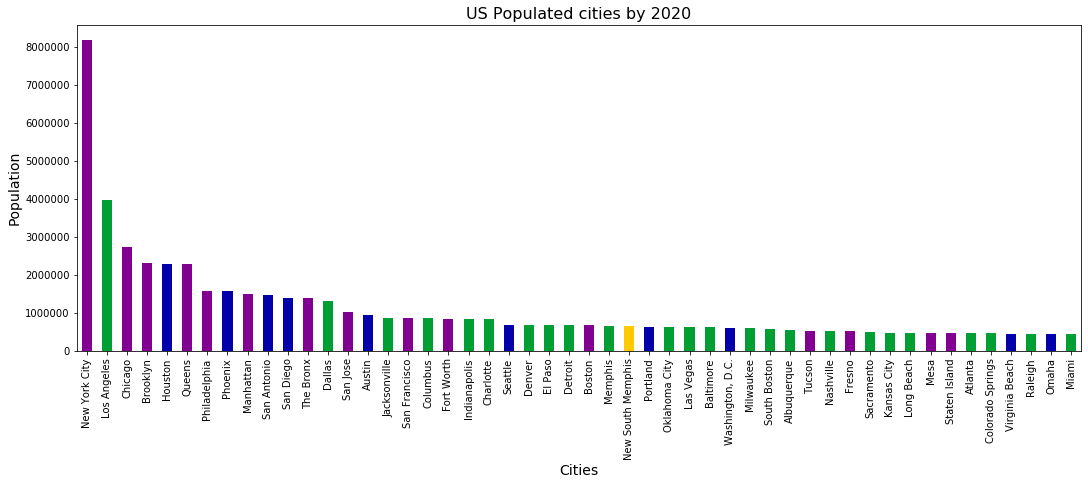

In [128]:
c_shades = cm.nipy_spectral(np.array([0.15, 0.43, 0.08, 0.75]))
bar_colors=np.array(c_shades)
clusters=df_us_cities_merged['Cluster Labels'].values

ax=df_us_cities_merged['population'].plot(kind='bar',
                                                    figsize=(18,6),
                                                    color=bar_colors[clusters]
                                                    )

ax.set_title("US Populated cities by 2020", fontsize=16)
ax.set_xlabel("Cities", fontsize=14)
ax.set_ylabel("Population", fontsize=14)

ax.set_xticklabels(df_us_cities_merged['city name'])

plt.show()

Above bar plot clearly shows that city - "New South Memphis" is marked separately by the cluster labels produced the KMeans algorithm indicating that it doesn't have much similarities when compared with rest of cities

In [129]:
us_venue_matrix=us_city_onehot.groupby('Neighborhood').sum().reset_index()
res_col=us_venue_matrix.columns.str.contains('Restaurant')
us_venue_matrix.iloc[0:5,list(res_col)]

,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fondue Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,New American Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,7,1,0,0,1,0,0,0,0,2,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0
1,0,2,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,3,0,0,0,1,0,0,0,0,1,2,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,0,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,3,0,1,1,0,0,0,1,0,0,0,4,0,0,0,0,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,0,0,4,0,0,0,0,0,1,0,2,0,0,1,1,0,1,1,1,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,6,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,3,0,0,0,0,2,0,0,0,0,0,0,0,1,0


In [130]:
us_venue_matrix=us_venue_matrix.merge(df_populated_cities[['city name','population']], left_on='Neighborhood', right_on='city name')
us_venue_matrix.drop('city name', axis=1, inplace=True)

us_venue_matrix=us_venue_matrix.merge(df_us_cities_merged[['city name', 'Cluster Labels']], left_on='Neighborhood', right_on='city name')
us_venue_matrix.drop('city name', axis=1, inplace=True)

In [131]:
cols_order=[us_venue_matrix.columns[0]] + list(us_venue_matrix.columns[-2:]) + list(us_venue_matrix.columns[1:-2])
us_venue_matrix=us_venue_matrix[cols_order]

In [132]:
us_venue_matrix.sort_values(by='population', ascending=False, inplace=True)
us_venue_matrix.reset_index(drop=True, inplace=True)
us_venue_matrix.index=us_venue_matrix.index+1

In [133]:
res_col=us_venue_matrix.columns.str.contains('Restaurant')
pd.concat([us_venue_matrix.iloc[0:5, 0], us_venue_matrix.iloc[0:5, list(res_col)]], axis=1)

,Neighborhood,Afghan Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Belgian Restaurant,Brazilian Restaurant,Burmese Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Fondue Restaurant,French Restaurant,German Restaurant,Gluten-free Restaurant,Greek Restaurant,Hawaiian Restaurant,Indian Restaurant,Indonesian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Mongolian Restaurant,New American Restaurant,Peruvian Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Shanghai Restaurant,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sushi Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,New York City,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,2,0,0,0,0,0,2,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,2,0,1,0,2,0,0,0,1,0
2,Los Angeles,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,2,1,5,0,0,1,2,3,0,0,0,1,0,0,0,4,0,2,0,0,0,0,4,0,0,0,1,0,0,1,0,0
3,Chicago,0,0,0,0,3,0,0,0,0,0,0,0,8,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,3,1,14,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2
4,Brooklyn,0,1,0,0,1,0,1,0,0,0,0,16,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0
5,Houston,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,0,1,0,0,1,0,3,0,0,0,1,0,0,0,0,0,1,0,0,4,0,1,0,0,0,1,0,0,0,0,0


In [134]:
venue_stats=us_venue_matrix.columns[3:]
us_venue_matrix['Total venues']=us_venue_matrix[venue_stats].sum(axis=1)

In [135]:
key_cols=['Neighborhood', 'population', 'Cluster Labels', 'Total venues']
df_us_venues_clust_grp=us_venue_matrix[key_cols].reset_index(drop=False)

In [136]:
df_us_venues_clust_grp=df_us_venues_clust_grp.groupby('Cluster Labels').agg(
Total_Population=pd.NamedAgg(column='population', aggfunc=sum),
Total_Clust_Venues=pd.NamedAgg(column='Total venues', aggfunc=sum),
Avg_venues=pd.NamedAgg(column='Total venues', aggfunc=np.mean),
Cluster_size=pd.NamedAgg(column='population', aggfunc=np.size),    
Min_rank=pd.NamedAgg(column='index', aggfunc=min),
Max_rank=pd.NamedAgg(column='index', aggfunc=max),
)


df_us_venues_clust_grp['population_venue_ratio']=df_us_venues_clust_grp['Total_Population']/df_us_venues_clust_grp['Total_Clust_Venues']
df_us_venues_clust_grp['venue_population_ratio']=(df_us_venues_clust_grp['Total_Clust_Venues']/df_us_venues_clust_grp['Total_Population'])*100000
df_us_venues_clust_grp

,Total_Population,Total_Clust_Venues,Avg_venues,Cluster_size,Min_rank,Max_rank,population_venue_ratio,venue_population_ratio
Cluster Labels,,,,,,,,
0,10470965,999,99.900000,10,5,49,10481.446446,9.540668
1,18734578,2383,99.291667,24,2,50,7861.761645,12.719795
2,25293628,1395,93.000000,15,1,44,18131.632975,5.515223
3,641608,20,20.000000,1,28,28,32080.400000,3.117168


Above data view clears shows the population to venue ratio is high in contrast to other clusters. In other words number of venues by taking population stats into consideration, the venues (i.e. restaurants) are less.

In [137]:
my_loc=us_venue_matrix['Neighborhood']=="New South Memphis"
New_South_memphis_stats=us_venue_matrix[my_loc].drop('Neighborhood', axis=1)#.reset_index(drop=True)
New_South_memphis_stats=New_South_memphis_stats.T.rename(columns={28:"Venues"})

In [138]:
New_South_memphis_stats=New_South_memphis_stats[New_South_memphis_stats["Venues"]!=0].sort_values(by="Venues", ascending=False)
New_South_memphis_stats=New_South_memphis_stats.T

Now let's see how many restaurants are there in "New South Memphis" and what are they. 

In [139]:
filter=New_South_memphis_stats.columns.str.contains('Restaurant')
all_venues=np.array(New_South_memphis_stats.columns)
restaurants=list(all_venues[filter])
New_South_memphis_stats[restaurants]

,Chinese Restaurant,Fast Food Restaurant
Venues,2,1


In [140]:
top_venues=us_city_onehot.iloc[:, 1:].sum(axis=0).sort_values(ascending=False)
df_us_highest_venues=pd.DataFrame(top_venues).T

To get the most frequent or most liked restaurant types by US people, let's prepare the view of number of restaurants by "type" sorted in descending order which gives us more insight

In [141]:
filter=df_us_highest_venues.columns.str.contains('Restaurant')
all_venues=np.array(df_us_highest_venues.columns)
restaurants=list(all_venues[filter])
df_us_highest_venues[restaurants]

,American Restaurant,Mexican Restaurant,Italian Restaurant,Seafood Restaurant,Restaurant,New American Restaurant,Sushi Restaurant,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,French Restaurant,Japanese Restaurant,Southern / Soul Food Restaurant,Thai Restaurant,Greek Restaurant,Latin American Restaurant,Indian Restaurant,Spanish Restaurant,Ramen Restaurant,Brazilian Restaurant,Middle Eastern Restaurant,Tapas Restaurant,Cajun / Creole Restaurant,Vietnamese Restaurant,Korean Restaurant,Peruvian Restaurant,German Restaurant,Cuban Restaurant,Theme Restaurant,Israeli Restaurant,Falafel Restaurant,Fondue Restaurant,Arepa Restaurant,Comfort Food Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Dumpling Restaurant,Argentinian Restaurant,Australian Restaurant,Dim Sum Restaurant,Filipino Restaurant,Mongolian Restaurant,South American Restaurant,Taiwanese Restaurant,Tex-Mex Restaurant,Hawaiian Restaurant,Belgian Restaurant,Gluten-free Restaurant,Afghan Restaurant,Udon Restaurant,Tibetan Restaurant,Austrian Restaurant,Indonesian Restaurant,Japanese Curry Restaurant,Kosher Restaurant,Molecular Gastronomy Restaurant,Shanghai Restaurant,Burmese Restaurant,Polish Restaurant,Portuguese Restaurant
0,146,129,112,79,59,57,53,35,35,29,26,26,25,24,23,21,20,19,18,16,13,12,11,10,10,10,9,9,8,7,5,5,4,4,4,4,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1


We have seen that "New South Memphis" has only "Chinese Restaurant" and "Fast Food Restaurant". Let's have a look at the remaining restaurants which are not there in the city not even in one place

In [143]:
existing_venues=list(New_South_memphis_stats.columns)
top_venues=list(df_us_highest_venues[restaurants].columns)

for t_venue in top_venues[0:20]:
    if not t_venue in existing_venues:
        print (t_venue)

American Restaurant
Mexican Restaurant
Italian Restaurant
Seafood Restaurant
Restaurant
New American Restaurant
Sushi Restaurant
Caribbean Restaurant
Mediterranean Restaurant
Vegetarian / Vegan Restaurant
Asian Restaurant
French Restaurant
Japanese Restaurant
Southern / Soul Food Restaurant
Thai Restaurant
Greek Restaurant
Latin American Restaurant
Indian Restaurant


## Results and Discussion <a name="results"></a>

Above analysis shows that out of 50 cities we have explored for most suitable location for a restaurant in united states by taking two main factors into account i.e. large populated cities and no such restaurant types in 2 mi radius, we have got one city - "New South Memphis".

All cities have got good number of venues (around 100 for top 10-15 cities) in 2 miles radius from the city center except the above one. The population stats found in the internet for city- New South Memphis by year 2020 is 641,608 which is a good number.

Verifying the details furthermore about the city- New South Memphis, statistics showed us that it is 28th ranked city by population in united states. Considering the 2 miles radius, the total number of venues at the "New South Memphis" city center are only 20, out of which only 3 are restaurants types i.e. 2 Chinese Restaurants and 1 Fast Food Restaurant.

The ratio of population to venues/restaurants are low when compared to other 49 cities. American and Mexican restaurants types stands in first and second place across all united states highly populated cities. Even the other restaurants types works well around the "New South Memphis" city center because it does not have any of those top 18 restaurants types in 2 miles radius.


## Conclusion <a name="conclusion"></a>

The main goal of the project is to provide extensive data report to stakeholders who are interested to expand the restaurant business in United states. The most favourable or suitable city for opening a restaurant within 2 miles from city center is identified as "New South Memphis" which is one of the largest cities by population in United states.

Final decision will be taken by group of investors to select the type of restaurant from the final list we have prepared and also other own business factors may be taken into consideration by investors such as which type of restaurant will be having comparatively less investment with high profits.